In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/MECD/2º\ ano/Tese/Implementação

In [ ]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super

In [ ]:
!pip install SciencePlots

In [ ]:
!pip install --quiet optuna

In [6]:
import joblib
import time

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import optuna

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
import seaborn as sns

In [7]:
train = pd.read_csv("final_miami_datasets/no_history/train.csv", index_col=[0,1])
train_X = train.iloc[:, :-1]
train_y = train.iloc[:, -1]

val = pd.read_csv("final_miami_datasets/no_history/val.csv")
val_X = val.iloc[:, :-1]
val_y = val.iloc[:, -1]

test = pd.read_csv("final_miami_datasets/no_history/test.csv")
test_X = test.iloc[:, :-1]
test_y = test.iloc[:, -1]

In [8]:
train_X = train_X.values
train_y = train_y.values
val_X = val_X.values
val_y = val_y.values
test_X = test_X.values
test_y = test_y.values

In [ ]:
def objective(trial):

  n_neighbors = trial.suggest_int("n_neighbors", 1, 1000)
  weights = trial.suggest_categorical("weights", ["uniform", "distance"])
  p = trial.suggest_int("p", 1, 2)

  ss = StandardScaler()
  knr = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p, n_jobs=-1)
  knr_pipe = Pipeline([("ss", ss), ("knr", knr)])
  knr_pipe = knr_pipe.fit(train_X, train_y)
  preds = knr_pipe.predict(val_X)

  return mean_squared_error(val_y, preds, squared=False)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

In [ ]:
joblib.dump(study, "models/knr_study.pkl")

In [44]:
def objective(trial):

  hidden_layer_size = trial.suggest_int("hidden_layer_size", 1, 100)
  activation = trial.suggest_categorical("activation", ["logistic", "tanh", "relu"])
  learning_rate_init = trial.suggest_float("learning_rate_init", 0.0001, 1)
  learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

  ss = StandardScaler()
  mlp = MLPRegressor(hidden_layer_sizes=(hidden_layer_size,), activation=activation,
                      learning_rate=learning_rate, learning_rate_init=learning_rate_init,
                      batch_size=batch_size, early_stopping=True, shuffle=True)
  mlp_pipe = Pipeline([("ss", ss), ("mlp", mlp)])

  mlp_pipe.fit(train_X, train_y)

  preds = mlp_pipe.predict(val_X)

  return mean_squared_error(val_y, preds, squared=False)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

In [ ]:
joblib.dump(study, "models/mlp_study.pkl")

In [9]:
knr_study = joblib.load("models/knr_study.pkl")
knr_trials_df = knr_study.trials_dataframe(attrs=("number", "value", "params"))
knr_trials_df["best_value"] = knr_trials_df["value"].cummin()
knr_trials_df.columns = ["Trial", "RMSE", "No. Neighbors", "Metric", "Weights", "Best RMSE"]
knr_trials_df["Metric"] = knr_trials_df["Metric"].map({1: "manhattan", 2: "euclidean"})
knr_param_importances = pd.Series(optuna.importance.get_param_importances(knr_study))

In [10]:
knr_trials_df.head()

,Trial,RMSE,No. Neighbors,Metric,Weights,Best RMSE
0,0,257.135475,653,euclidean,distance,257.135475
1,1,254.495148,829,manhattan,uniform,254.495148
2,2,281.490311,71,euclidean,distance,254.495148
3,3,254.280322,898,manhattan,distance,254.280322
4,4,260.303923,324,euclidean,uniform,254.280322


In [11]:
mlp_study = joblib.load("models/mlp_study.pkl")
mlp_trials_df = mlp_study.trials_dataframe(attrs=("number", "value", "params"))
mlp_trials_df["best_value"] = mlp_trials_df["value"].cummin()
mlp_trials_df.columns = ["Trial", "RMSE", "Activation", "Batch Size", "Hidden Layer Size", "Learning Rate", "Learning Rate Init", "Best RMSE"]
mlp_param_importances = pd.Series(optuna.importance.get_param_importances(mlp_study))

In [12]:
mlp_trials_df.head()

,Trial,RMSE,Activation,Batch Size,Hidden Layer Size,Learning Rate,Learning Rate Init,Best RMSE
0,0,261.356008,tanh,32,26,constant,0.178154,261.356008
1,1,282.232306,relu,32,3,constant,0.480916,261.356008
2,2,262.359274,tanh,64,45,adaptive,0.813444,261.356008
3,3,255.407959,logistic,256,85,constant,0.806005,255.407959
4,4,275.206891,logistic,128,5,invscaling,0.370549,255.407959


In [13]:
print(knr_study.best_trial.value)
print(mlp_study.best_trial.value)

254.0259457876422
250.96665912448682


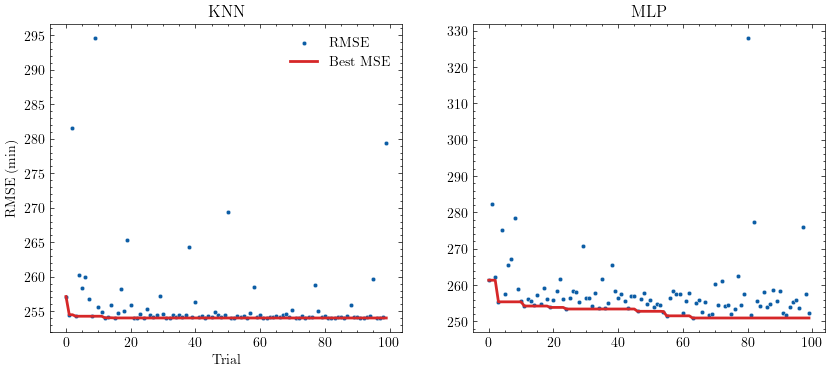

In [48]:
# Optimization History
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.scatterplot(data=knr_trials_df, x="Trial", y="RMSE", s=10, label="RMSE", ax=axs[0])
sns.lineplot(data=knr_trials_df, x="Trial", y="Best RMSE", linewidth=2, color="tab:red", label="Best MSE", ax=axs[0])

sns.scatterplot(data=mlp_trials_df, x="Trial", y="RMSE", s=10, ax=axs[1])
sns.lineplot(data=mlp_trials_df, x="Trial", y="Best RMSE", linewidth=2, color="tab:red", legend=False, ax=axs[1])

axs[0].legend()
axs[0].set_ylabel("RMSE (min)")
axs[0].set_title("KNN")
axs[1].set_title("MLP")
axs[1].set_xlabel("")
axs[1].set_ylabel("")

plt.savefig("figures/history")
plt.show()

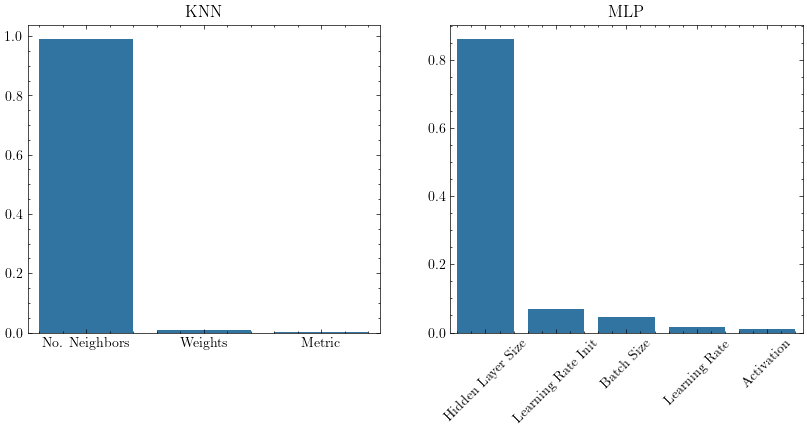

In [49]:
# Hyperparameters Importances
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.barplot(x=knr_param_importances.index, y=knr_param_importances.values, color="tab:blue", ax=axs[0])
sns.barplot(x=mlp_param_importances.index, y=mlp_param_importances.values, color="tab:blue", ax=axs[1])

axs[0].set_title("KNN")
axs[1].set_title("MLP")
axs[0].set_xticks(np.arange(3), ["No. Neighbors", "Weights", "Metric"])
axs[1].set_xticks(np.arange(5), ["Hidden Layer Size", "Learning Rate Init", "Batch Size", "Learning Rate", "Activation"], rotation=45)

plt.savefig("figures/param_importance")
plt.show()

In [105]:
cmap = sns.color_palette("Blues", as_cmap=True)

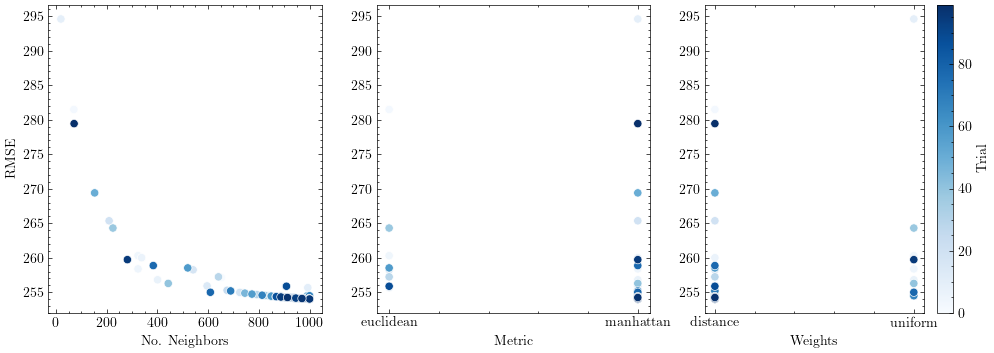

In [115]:
# Hyperparameters Performances (KNR)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
sns.scatterplot(data=knr_trials_df, x="No. Neighbors", y="RMSE", hue="Trial", palette=cmap, legend=False, ax=axs[0])
sns.scatterplot(data=knr_trials_df, x="Metric", y="RMSE", hue="Trial", palette=cmap, legend=False, ax=axs[1])
sns.scatterplot(data=knr_trials_df, x="Weights", y="RMSE", hue="Trial", palette=cmap, legend=False, ax=axs[2])

axs[1].set_ylabel("")
axs[2].set_ylabel("")

dummy_cmap = plt.cm.ScalarMappable(cmap=cmap)
dummy_cmap.set_clim(0, knr_trials_df["Trial"].max())

cbar = plt.colorbar(dummy_cmap, ax=axs[2])
cbar.set_label("Trial")

plt.savefig("figures/knn_slice")
plt.show()

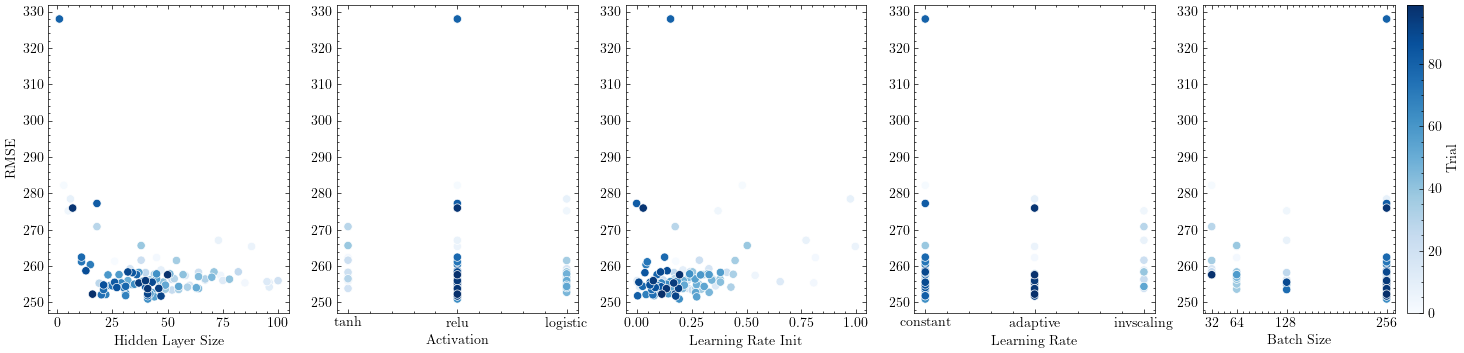

In [114]:
# Hyperparameters Performances (MLP)
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(18, 4))

sns.scatterplot(data=mlp_trials_df, x="Hidden Layer Size", y="RMSE", hue="Trial", palette=cmap, legend=False, ax=axs[0])
sns.scatterplot(data=mlp_trials_df, x="Activation", y="RMSE", hue="Trial", palette=cmap, legend=False, ax=axs[1])
sns.scatterplot(data=mlp_trials_df, x="Learning Rate Init", y="RMSE", hue="Trial", palette=cmap, legend=False, ax=axs[2])
sns.scatterplot(data=mlp_trials_df, x="Learning Rate", y="RMSE", hue="Trial", palette=cmap, legend=False, ax=axs[3])
sns.scatterplot(data=mlp_trials_df, x="Batch Size", y="RMSE", hue="Trial", palette=cmap, legend=False, ax=axs[4])

axs[1].set_ylabel("")
axs[2].set_ylabel("")
axs[3].set_ylabel("")
axs[4].set_ylabel("")
axs[4].set_xticks(np.unique(mlp_trials_df["Batch Size"]), ["32", "64", "128", "256"])

dummy_cmap = plt.cm.ScalarMappable(cmap=cmap)
dummy_cmap.set_clim(0, knr_trials_df["Trial"].max())

cbar = plt.colorbar(dummy_cmap, ax=axs[4])
cbar.set_label("Trial")

plt.savefig("figures/mlp_slice")
plt.show()

# Evaluate Models

In [116]:
knr_study.best_params

{'n_neighbors': 1000, 'weights': 'distance', 'p': 1}

In [117]:
mlp_study.best_params

{'hidden_layer_size': 41,
 'activation': 'relu',
 'learning_rate_init': 0.1937581607625909,
 'learning_rate': 'constant',
 'batch_size': 256}

In [5]:
knr_pipe = Pipeline([("ss", StandardScaler()), ("knr", KNeighborsRegressor(n_neighbors=1000, weights="distance", p=1, n_jobs=-1))])
mlp_pipe = Pipeline([("ss", StandardScaler()),
                     ("mlp", MLPRegressor(hidden_layer_sizes=(41,), activation="relu",
                                         learning_rate="constant", learning_rate_init=0.1937581607625909,
                                         batch_size=256, early_stopping=True, random_state=1, shuffle=True))])

###### 24 hours max

In [6]:
rtt_1day_index_train = np.where(train_y < (24 * 60))[0]
rtt_1day_index_val = np.where(val_y < (24 * 60))[0]
rtt_1day_index_test = np.where(test_y < (24 * 60))[0]

train_X_24 = train_X[rtt_1day_index_train]
train_y_24 = train_y[rtt_1day_index_train]
val_X_24 = val_X[rtt_1day_index_val]
val_y_24 = val_y[rtt_1day_index_val]
test_X_24 = test_X[rtt_1day_index_test]
test_y_24 = test_y[rtt_1day_index_test]

train_X_24 = np.vstack((train_X_24, val_X_24))
train_y_24 = np.hstack((train_y_24, val_y_24))

In [7]:
knr_pipe.fit(train_X_24, train_y_24)
mlp_pipe.fit(train_X_24, train_y_24)

Pipeline(steps=[('ss', StandardScaler()),
                ('mlp',
                 MLPRegressor(batch_size=256, early_stopping=True,
                              hidden_layer_sizes=(41,),
                              learning_rate_init=0.1937581607625909,
                              random_state=1))])

In [8]:
joblib.dump(knr_pipe, "models/knr_pipe_24_trained.pkl")
joblib.dump(mlp_pipe, "models/mlp_pipe_24_trained.pkl")

['models/mlp_pipe_24_trained.pkl']

In [9]:
start = time.time()
knr_preds = knr_pipe.predict(test_X_24)
print(f"K-Nearest Neighbors Prediction Time: {time.time() - start}")

start = time.time()
mlp_preds = mlp_pipe.predict(test_X_24)
print(f"Multilayer Perceptron Prediction Time: {time.time() - start}")

K-Nearest Neighbors Prediction Time: 38.02941274642944
Multilayer Perceptron Prediction Time: 0.05187273025512695


In [10]:
knr_preds_targets_df_24 = pd.DataFrame(data=np.vstack((knr_preds, test_y_24)).T, columns=["Preds", "Targets"])
mlp_preds_targets_df_24 = pd.DataFrame(data=np.vstack((mlp_preds, test_y_24)).T, columns=["Preds", "Targets"])

In [11]:
bins_24 = np.array([-1.0, 4.0, 8.0, 12.0, 16.0, 20.0, 25.0]) * 60
labels_24 = ["0-4", "4-8", "8-12", "12-16", "16-20", "20-24"]
knr_preds_targets_df_24["TargetBinned"] = pd.cut(knr_preds_targets_df_24["Targets"], bins=bins_24, labels=labels_24)
mlp_preds_targets_df_24["TargetBinned"] = pd.cut(mlp_preds_targets_df_24["Targets"], bins=bins_24, labels=labels_24)

In [12]:
mape = mean_absolute_percentage_error(knr_preds_targets_df_24["Targets"], knr_preds_targets_df_24["Preds"])
mae = mean_absolute_error(knr_preds_targets_df_24["Targets"], knr_preds_targets_df_24["Preds"])
rmse = mean_squared_error(knr_preds_targets_df_24["Targets"], knr_preds_targets_df_24["Preds"], squared=False)
r2 = r2_score(knr_preds_targets_df_24["Targets"], knr_preds_targets_df_24["Preds"])

metrics_knr_df_24 = pd.DataFrame(data=[[mape, mae, rmse, r2]],
                                 columns=["MAPE", "MAE", "RMSE", "R2"],
                                 index=["KNN"])

mape = mean_absolute_percentage_error(mlp_preds_targets_df_24["Targets"], mlp_preds_targets_df_24["Preds"])
mae = mean_absolute_error(mlp_preds_targets_df_24["Targets"], mlp_preds_targets_df_24["Preds"])
rmse = mean_squared_error(mlp_preds_targets_df_24["Targets"], mlp_preds_targets_df_24["Preds"], squared=False)
r2 = r2_score(mlp_preds_targets_df_24["Targets"], mlp_preds_targets_df_24["Preds"])

metrics_mlp_df_24 = pd.DataFrame(data=[[mape, mae, rmse, r2]],
                                 columns=["MAPE", "MAE", "RMSE", "R2"],
                                 index=["MLP"])

metrics_df_24 = pd.concat((metrics_knr_df_24, metrics_mlp_df_24), axis=0)

In [13]:
display(metrics_df_24)
print(metrics_df_24.style.to_latex())

,MAPE,MAE,RMSE,R2
KNN,0.229013,110.058497,178.866647,0.787736
MLP,0.239669,112.156822,177.532141,0.790892


\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
KNN & 0.229013 & 110.058497 & 178.866647 & 0.787736 \\
MLP & 0.239669 & 112.156822 & 177.532141 & 0.790892 \\
\end{tabular}



In [14]:
knr_preds_targets_df_24["Error"] = knr_preds_targets_df_24["Targets"] - knr_preds_targets_df_24["Preds"]
mlp_preds_targets_df_24["Error"] = mlp_preds_targets_df_24["Targets"] - mlp_preds_targets_df_24["Preds"]

errors_df_24 = pd.concat((knr_preds_targets_df_24["Error"], mlp_preds_targets_df_24["Error"]), axis=1, keys=["KNN", "MLP"])
errors_df_24["TargetBinned"] = mlp_preds_targets_df_24["TargetBinned"]
errors_df_24.set_index(keys="TargetBinned", inplace=True)

errors_df_24 = errors_df_24.melt(value_vars=["KNN", "MLP"], var_name="Model", value_name="Error", ignore_index=False).reset_index()
errors_df_24["AbsError"] = errors_df_24["Error"].abs()

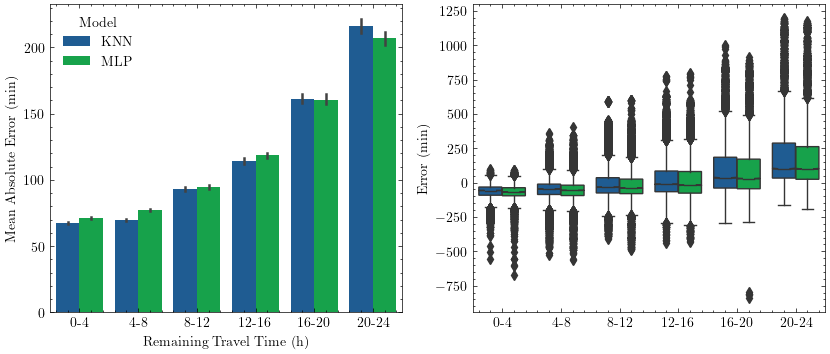

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.barplot(data=errors_df_24, x="TargetBinned", y="AbsError", hue="Model", estimator="mean", ax=axs[0])
axs[0].set_ylabel("Mean Absolute Error (min)")
axs[0].set_xlabel("Remaining Travel Time (h)")

sns.boxplot(data=errors_df_24, x="TargetBinned", y="Error", hue="Model", notch=True, ax=axs[1])
axs[1].set_ylabel("Error (min)")
axs[1].set_xlabel("")
axs[1].get_legend().remove()

plt.savefig("figures/mae_by_time_miami_24")
plt.show()

###### 48 hours max

In [16]:
train_X = np.vstack((train_X, val_X))
train_y = np.hstack((train_y, val_y))

In [17]:
knr_pipe.fit(train_X, train_y)
mlp_pipe.fit(train_X, train_y)

Pipeline(steps=[('ss', StandardScaler()),
                ('mlp',
                 MLPRegressor(batch_size=256, early_stopping=True,
                              hidden_layer_sizes=(41,),
                              learning_rate_init=0.1937581607625909,
                              random_state=1))])

In [18]:
joblib.dump(knr_pipe, "models/knr_pipe_trained.pkl")
joblib.dump(mlp_pipe, "models/mlp_pipe_trained.pkl")

['models/mlp_pipe_trained.pkl']

In [19]:
knr_pipe = joblib.load("models/knr_pipe_trained.pkl")
mlp_pipe = joblib.load("models/mlp_pipe_trained.pkl")

In [20]:
start = time.time()
knr_preds = knr_pipe.predict(test_X)
print(f"K-Nearest Neighbors Prediction Time: {time.time() - start}")

start = time.time()
mlp_preds = mlp_pipe.predict(test_X)
print(f"Multilayer Perceptron Prediction Time: {time.time() - start}")

K-Nearest Neighbors Prediction Time: 52.46578574180603
Multilayer Perceptron Prediction Time: 0.2073957920074463


In [21]:
knr_preds_targets_df = pd.DataFrame(data=np.vstack((knr_preds, test_y)).T, columns=["Preds", "Targets"])
mlp_preds_targets_df = pd.DataFrame(data=np.vstack((mlp_preds, test_y)).T, columns=["Preds", "Targets"])

In [22]:
bins = np.array([-1.0, 8.0, 16.0, 24.0, 32.0, 40.0, 49.0]) * 60
labels = ["0-8", "8-16", "16-24", "24-32", "32-40", "40-48"]
knr_preds_targets_df["TargetBinned"] = pd.cut(knr_preds_targets_df["Targets"], bins=bins, labels=labels)
mlp_preds_targets_df["TargetBinned"] = pd.cut(mlp_preds_targets_df["Targets"], bins=bins, labels=labels)

In [23]:
mape = mean_absolute_percentage_error(knr_preds_targets_df["Targets"], knr_preds_targets_df["Preds"])
mae = mean_absolute_error(knr_preds_targets_df["Targets"], knr_preds_targets_df["Preds"])
rmse = mean_squared_error(knr_preds_targets_df["Targets"], knr_preds_targets_df["Preds"], squared=False)
r2 = r2_score(knr_preds_targets_df["Targets"], knr_preds_targets_df["Preds"])

metrics_knr_df = pd.DataFrame(data=[[mape, mae, rmse, r2]],
                                 columns=["MAPE", "MAE", "RMSE", "R2"],
                                 index=["KNN"])

mape = mean_absolute_percentage_error(mlp_preds_targets_df["Targets"], mlp_preds_targets_df["Preds"])
mae = mean_absolute_error(mlp_preds_targets_df["Targets"], mlp_preds_targets_df["Preds"])
rmse = mean_squared_error(mlp_preds_targets_df["Targets"], mlp_preds_targets_df["Preds"], squared=False)
r2 = r2_score(mlp_preds_targets_df["Targets"], mlp_preds_targets_df["Preds"])

metrics_mlp_df = pd.DataFrame(data=[[mape, mae, rmse, r2]],
                                 columns=["MAPE", "MAE", "RMSE", "R2"],
                                 index=["MLP"])

metrics_df = pd.concat((metrics_knr_df, metrics_mlp_df), axis=0)

In [24]:
display(metrics_df)
print(metrics_df.style.to_latex())

,MAPE,MAE,RMSE,R2
KNN,0.264342,181.452901,308.437348,0.750171
MLP,0.251811,176.417516,291.029400,0.777575


\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
KNN & 0.264342 & 181.452901 & 308.437348 & 0.750171 \\
MLP & 0.251811 & 176.417516 & 291.029400 & 0.777575 \\
\end{tabular}



In [25]:
knr_preds_targets_df["Error"] = knr_preds_targets_df["Targets"] - knr_preds_targets_df["Preds"]
mlp_preds_targets_df["Error"] = mlp_preds_targets_df["Targets"] - mlp_preds_targets_df["Preds"]

errors_df = pd.concat((knr_preds_targets_df["Error"], mlp_preds_targets_df["Error"]), axis=1, keys=["KNN", "MLP"])
errors_df["TargetBinned"] = mlp_preds_targets_df["TargetBinned"]
errors_df.set_index(keys="TargetBinned", inplace=True)

errors_df = errors_df.melt(value_vars=["KNN", "MLP"], var_name="Model", value_name="Error", ignore_index=False).reset_index()
errors_df["AbsError"] = errors_df["Error"].abs()

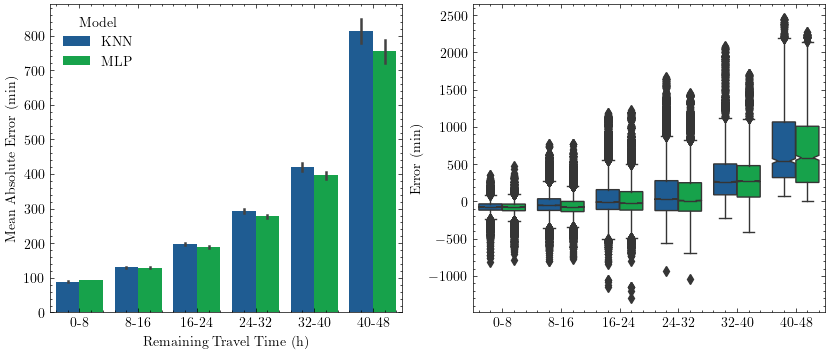

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.barplot(data=errors_df, x="TargetBinned", y="AbsError", hue="Model", estimator="mean", ax=axs[0])
axs[0].set_ylabel("Mean Absolute Error (min)")
axs[0].set_xlabel("Remaining Travel Time (h)")

sns.boxplot(data=errors_df, x="TargetBinned", y="Error", hue="Model", notch=True , ax=axs[1])
axs[1].set_ylabel("Error (min)")
axs[1].set_xlabel("")
axs[1].get_legend().remove()

plt.savefig("figures/mae_by_time_miami_48")
plt.show()

# Test on the 2nd dataset

In [27]:
train = pd.read_csv("final_france_datasets/no_history/train.csv", index_col=[0,1])
train_X = train.iloc[:, :-1]
train_y = train.iloc[:, -1]

val = pd.read_csv("final_france_datasets/no_history/val.csv")
val_X = val.iloc[:, :-1]
val_y = val.iloc[:, -1]

test = pd.read_csv("final_france_datasets/no_history/test.csv")
test_X = test.iloc[:, :-1]
test_y = test.iloc[:, -1]

In [28]:
train_X = train_X.values
train_y = train_y.values
val_X = val_X.values
val_y = val_y.values
test_X = test_X.values
test_y = test_y.values

In [29]:
train_X = np.vstack((train_X, val_X))
train_y = np.hstack((train_y, val_y))

In [30]:
knr_pipe.fit(train_X, train_y)
mlp_pipe.fit(train_X, train_y)

Pipeline(steps=[('ss', StandardScaler()),
                ('mlp',
                 MLPRegressor(batch_size=256, early_stopping=True,
                              hidden_layer_sizes=(41,),
                              learning_rate_init=0.1937581607625909,
                              random_state=1))])

In [32]:
joblib.dump(knr_pipe, "models/knr_pipe_trained_france.pkl")
joblib.dump(mlp_pipe, "models/mlp_pipe_trained_france.pkl")

['models/mlp_pipe_trained_france.pkl']

In [33]:
knr_pipe = joblib.load("models/knr_pipe_trained_france.pkl")
mlp_pipe = joblib.load("models/mlp_pipe_trained_france.pkl")

In [34]:
start = time.time()
knr_preds = knr_pipe.predict(test_X)
print(time.time() - start)

1.039790153503418


In [36]:
start = time.time()
mlp_preds = mlp_pipe.predict(test_X)
print(time.time() - start)

0.00469970703125


In [37]:
knr_preds_targets_df = pd.DataFrame(data=np.vstack((knr_preds, test_y)).T, columns=["Preds", "Targets"])
mlp_preds_targets_df = pd.DataFrame(data=np.vstack((mlp_preds, test_y)).T, columns=["Preds", "Targets"])

In [38]:
bins = np.array([-1.0, 8.0, 16.0, 24.0, 32.0, 40.0, 49.0]) * 60
labels = ["0-8", "8-16", "16-24", "24-32", "32-40", "40-48"]
knr_preds_targets_df["TargetBinned"] = pd.cut(knr_preds_targets_df["Targets"], bins=bins, labels=labels)
mlp_preds_targets_df["TargetBinned"] = pd.cut(mlp_preds_targets_df["Targets"], bins=bins, labels=labels)

In [39]:
mape = mean_absolute_percentage_error(knr_preds_targets_df["Targets"], knr_preds_targets_df["Preds"])
mae = mean_absolute_error(knr_preds_targets_df["Targets"], knr_preds_targets_df["Preds"])
rmse = mean_squared_error(knr_preds_targets_df["Targets"], knr_preds_targets_df["Preds"], squared=False)
r2 = r2_score(knr_preds_targets_df["Targets"], knr_preds_targets_df["Preds"])

metrics_knr_df = pd.DataFrame(data=[[mape, mae, rmse, r2]],
                                 columns=["MAPE", "MAE", "RMSE", "R2"],
                                 index=["KNN"])

mape = mean_absolute_percentage_error(mlp_preds_targets_df["Targets"], mlp_preds_targets_df["Preds"])
mae = mean_absolute_error(mlp_preds_targets_df["Targets"], mlp_preds_targets_df["Preds"])
rmse = mean_squared_error(mlp_preds_targets_df["Targets"], mlp_preds_targets_df["Preds"], squared=False)
r2 = r2_score(mlp_preds_targets_df["Targets"], mlp_preds_targets_df["Preds"])

metrics_mlp_df = pd.DataFrame(data=[[mape, mae, rmse, r2]],
                                 columns=["MAPE", "MAE", "RMSE", "R2"],
                                 index=["MLP"])

metrics_df = pd.concat((metrics_knr_df, metrics_mlp_df), axis=0)

In [41]:
display(metrics_df)
print(metrics_df.style.to_latex())

,MAPE,MAE,RMSE,R2
KNN,1.982544e+15,287.018207,502.375429,0.348290
MLP,2.492969e+15,287.889424,502.994217,0.346683


\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
KNN & 1982544177743726.750000 & 287.018207 & 502.375429 & 0.348290 \\
MLP & 2492969079137504.000000 & 287.889424 & 502.994217 & 0.346683 \\
\end{tabular}



In [42]:
knr_preds_targets_df["Error"] = knr_preds_targets_df["Targets"] - knr_preds_targets_df["Preds"]
mlp_preds_targets_df["Error"] = mlp_preds_targets_df["Targets"] - mlp_preds_targets_df["Preds"]

errors_df = pd.concat((knr_preds_targets_df["Error"], mlp_preds_targets_df["Error"]), axis=1, keys=["KNN", "MLP"])
errors_df["TargetBinned"] = mlp_preds_targets_df["TargetBinned"]
errors_df.set_index(keys="TargetBinned", inplace=True)

errors_df = errors_df.melt(value_vars=["KNN", "MLP"], var_name="Model", value_name="Error", ignore_index=False).reset_index()
errors_df["AbsError"] = errors_df["Error"].abs()

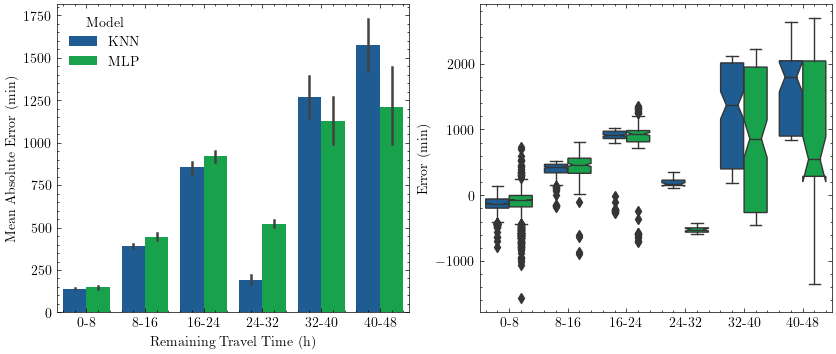

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.barplot(data=errors_df, x="TargetBinned", y="AbsError", hue="Model", estimator="mean", ax=axs[0])
axs[0].set_ylabel("Mean Absolute Error (min)")
axs[0].set_xlabel("Remaining Travel Time (h)")

sns.boxplot(data=errors_df, x="TargetBinned", y="Error", hue="Model", notch=True , ax=axs[1])
axs[1].set_ylabel("Error (min)")
axs[1].set_xlabel("")
axs[1].get_legend().remove()

plt.savefig("figures/mae_by_time_france_48")
plt.show()